In [61]:
import pandas as pd
import numpy as np
import scipy.stats as stats
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

## Data Processing

In [62]:
dataset = "pfizer"
tm_file = "Wuhan-A-rbd_tmscores.csv"
agg = "mean"
group = True if dataset == "LC" else False

def log_base(x, base):
    return np.log(x) / np.log(base)


if dataset == "LC": 
    VARIANTS = ['Wuhan-A', 'Delta-B.1.617.2', 'Omicron-BA.1']
    # load + clean as before
    titer_table = pd.read_excel("titer-data/LC_case_control.xlsx")
    meta_table = pd.read_csv("titer-data/LC_Case_Control_metadata.csv")
    # Rename columns
    titer_table.columns = ['Participant', 'Wuhan-A', 'Delta-B.1.617.2', 'Omicron-BA.1']
    titer_table = titer_table.merge(meta_table, on='Participant', how='left')

    # force numeric and drop any new NaNs
    for col in VARIANTS:
        titer_table[col] = pd.to_numeric(titer_table[col], errors='coerce')
    titer_table = titer_table.dropna(subset=VARIANTS)

    # now remove outliers only on the titer columns
    titer_cols = VARIANTS
    mask_high  =  (titer_table[titer_cols] > 15000).any(axis=1)
    mask_low   =  (titer_table[titer_cols] <=     1).any(axis=1)
    titer_table = titer_table[~(mask_high | mask_low)].reset_index(drop=True)

    titer_table = titer_table.dropna()

    df_long = titer_table.melt(
        id_vars=['Participant', 'Sex', 'Age'],   # keep Sex and Age as id_vars (columns to keep)
        value_vars=VARIANTS,  # only these are melted
        var_name='Variant',
        value_name='Titer'
    )
    df_long['Group'] = df_long['Participant'].apply(lambda x: 'Case' if x.startswith('CA') else 'Control')
    df_long['log10_Titer'] = log_base(df_long['Titer'], 10)


elif dataset == "pfizer":
    VARIANTS = ["Wuhan-A", "Delta-B.1.617.2", "Omicron-BA.1", "Beta-B.1.351"]
    files = ["titer-data/pfizer-wuhan.csv", "titer-data/pfizer-delta.csv", "titer-data/pfizer-omicron.csv", "titer-data/pfizer-beta.csv"]
    if agg == "mean":
        df_list = [pd.read_csv(file).mean(axis=0) for file in files]
    elif agg == "sum":
        df_list = [pd.read_csv(file).sum(axis=0) for file in files]
    df_long = pd.concat(df_list, axis=1, join="inner").dropna().reset_index()
    df_long.columns = ["Participant", "Wuhan-A", "Delta-B.1.617.2", "Omicron-BA.1", "Beta-B.1.351"]
    df_long = df_long.dropna()
    df_long =df_long.melt(
        id_vars=["Participant"],
        value_vars=VARIANTS,
        var_name="Variant",
        value_name="Titer"
    )
    df_long = df_long[1:]
    df_long['log10_Titer'] = log_base(df_long['Titer'], 10)

elif dataset == "pregnancy":
    VARIANTS = ["Wuhan-A", "Delta-B.1.617.2", "Omicron-BA.1", "Beta-B.1.351"]
    df_long = pd.read_csv("titer-data/pregnancy.csv").T[1:].dropna().reset_index()
    df_long.columns = ["Participant", "Wuhan-A", "Delta-B.1.617.2", "Omicron-BA.1", "Beta-B.1.351"]
    df_long = df_long.melt(
        id_vars=["Participant"],
        value_vars=VARIANTS,
        var_name="Variant",
        value_name="Titer"
    )
    df_long['log10_Titer'] = log_base(df_long['Titer'], 10)


In [63]:
df_long.head()

,Participant,Variant,Titer,log10_Titer
1,2001,Wuhan-A,8732.533333,3.941140
2,2002,Wuhan-A,5470.375000,3.738017
3,2004,Wuhan-A,7910.275000,3.898192
4,2005,Wuhan-A,6682.625000,3.824947
5,2006,Wuhan-A,10032.925000,4.001428


In [64]:
tm_scores = pd.read_csv(tm_file)
tm_scores["variant"] = tm_scores["subject"].str.replace("-rbd.pdb", "")
tm_scores.set_index("variant", inplace=True)
tm_scores = tm_scores["tm_score"].to_dict()

tm_scores

{'Wuhan-A': 1.0,
 'Alpha-B.1.1.7': 0.829475,
 'Beta-B.1.351': 0.881635,
 'Delta-B.1.617.2': 0.78742,
 'Gamma-P.1': 0.877675,
 'Omicron-BA.1': 0.72631,
 'Omicron-BA.2.12.1': 0.849785}

### The binding stability of hACE2 and RBD complexes were in the order of Omicron 
### BA.1.1 > Omicron BA.5.2.1 > Omicron BA.2.12.1 > Delta > Omicron-B.1.529.1 > Gamma > Alpha > Beta > Original Wuhan strain 
### due to the increase of the KD.

In [113]:
sorted([(key, val) for key, val in tm_scores.items()], key=lambda x: x[1])

[('Omicron-BA.1', 0.72631),
 ('Delta-B.1.617.2', 0.78742),
 ('Alpha-B.1.1.7', 0.829475),
 ('Omicron-BA.2.12.1', 0.849785),
 ('Gamma-P.1', 0.877675),
 ('Beta-B.1.351', 0.881635),
 ('Wuhan-A', 1.0)]

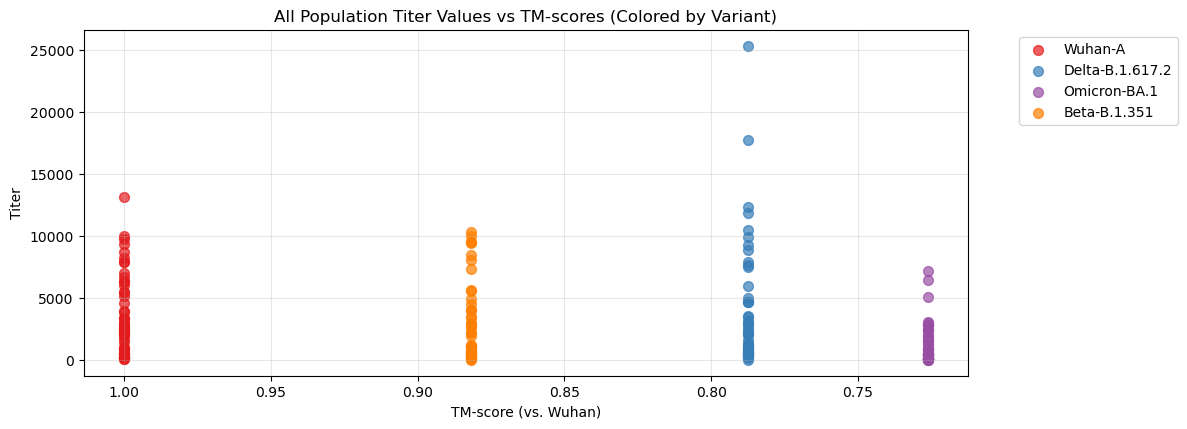

=== POPULATION SUMMARY ===
Total data points: 199
Unique variants: 4
TM-score range: 0.726 to 1.000
Titer range: 8.5 to 25346.5

=== BY VARIANT ===
                 Count  Mean_Titer  Std_Titer  TM_Score
Variant                                                
Beta-B.1.351        50    2895.992   3144.306     0.882
Delta-B.1.617.2     50    4000.705   5006.912     0.787
Omicron-BA.1        50    1279.568   1592.438     0.726
Wuhan-A             49    3684.692   3269.474     1.000

Correlation between TM-score and Titer: 0.168


In [65]:
# Plot all population titer values against tm-scores
plt.figure(figsize=(12, 8))

# Map tm-scores to the dataframe
df_plot = df_long.copy()
df_plot['tm_score'] = df_plot['Variant'].map(tm_scores)

# Remove any rows where tm_score is missing
df_plot = df_plot.dropna(subset=['tm_score'])

# Option 1: Color by variant
plt.subplot(2, 1, 1)
variants = df_plot['Variant'].unique()
colors = plt.cm.Set1(np.linspace(0, 0.5, len(variants)))

for i, variant in enumerate(variants):
    variant_data = df_plot[df_plot['Variant'] == variant]
    plt.scatter(variant_data['tm_score'], variant_data['Titer'], 
                color=colors[i], alpha=0.7, label=variant, s=50)

plt.xlabel('TM-score (vs. Wuhan)')
plt.ylabel('Titer')
plt.title('All Population Titer Values vs TM-scores (Colored by Variant)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, alpha=0.3)
plt.gca().invert_xaxis()

plt.tight_layout()
plt.show()

# Summary statistics
print("=== POPULATION SUMMARY ===")
print(f"Total data points: {len(df_plot)}")
print(f"Unique variants: {df_plot['Variant'].nunique()}")
print(f"TM-score range: {df_plot['tm_score'].min():.3f} to {df_plot['tm_score'].max():.3f}")
print(f"Titer range: {df_plot['Titer'].min():.1f} to {df_plot['Titer'].max():.1f}")

# Variant breakdown
print("\n=== BY VARIANT ===")
variant_summary = df_plot.groupby('Variant').agg({
    'Titer': ['count', 'mean', 'std'],
    'tm_score': 'first'
}).round(3)
variant_summary.columns = ['Count', 'Mean_Titer', 'Std_Titer', 'TM_Score']
print(variant_summary)

# Correlation analysis
correlation = df_plot['tm_score'].corr(df_plot['Titer'])
print(f"\nCorrelation between TM-score and Titer: {correlation:.3f}")

## Model Framework

### Mixed Linear Models with `smf.mixedlm`

## What are Mixed Linear Models?

**Mixed Linear Models (MLMs)** are statistical models that handle data with **both fixed and random effects**. They're particularly useful when you have:
- **Repeated measurements** on the same subjects
- **Hierarchical/clustered data** (e.g., patients within hospitals, students within schools)
- **Correlated observations** that violate independence assumptions of regular linear regression

## Key Components

### 1. **Fixed Effects** 
- Effects that are **consistent across all groups**
- Traditional regression coefficients
- Example: `log10_Titer ~ Tm`

### 2. **Random Effects**
- Effects that **vary by group/subject**
- Account for individual titer differences

## Why Use Mixed Models for Titer Data?

### **Problem**: Multiple measurements per participant
- Each participant tested against multiple variants (Wuhan, Delta, Omicron, etc.)
- Observations from same person are **correlated** (not independent)
- Regular regression assumes independence → **inflated significance**

### **Solution**: Mixed Linear Model
```python
# Account for participant-specific baseline responses
formula = "log10_Titer ~ Tm"  # Fixed effects
groups = df["Participant"]                    # Random intercepts per participant
```

## Model Interpretation

### **Fixed Effects** (`result.fe_params`)
- **Intercept**: Average log10-titer when all predictors = 0
- **Tm**: Change in log10-titer per unit change in TM-score
- **Optional-C(Sex)[T.Male]**: Difference between Male vs Female (reference)
- **Optional-Age**: Change in log10-titer per year of age

### **Random Effects** (`result.random_effects`)
- **Random Intercepts**: Each participant's deviation from population average
- Captures individual immune system differences


In [47]:
class TiterModel:
    def __init__(self):
        """
        Simple titer model that fits to whatever data is provided.
        """
        self.result = None
        self.tm_scores = None

    def fit(self, data, tm_scores, reml=True, formula="log10_Titer ~ Tm + C(Sex) + Age"):
        """Fit mixedlm to the provided data."""
        
        # Initialize Data
        self.df = data.copy()
        self.tm_scores = tm_scores

        # inject Tm and log10_Titer
        self.df['Tm'] = self.df['Variant'].map(self.tm_scores)
        self.df['log10_Titer'] = np.log10(self.df['Titer'])
        model = smf.mixedlm(formula, data=self.df, groups=self.df["Participant"])
        self.result = model.fit(reml=reml)
        return self.result

    def predict(self, variant, sex, age, participant_id=None,
                use_random_effect=False, return_log10=False):
        """
        Predict titer for a new sample.
        
        variant: str, one of tm_scores keys
        sex:  value for Sex column
        age:  numeric
        participant_id: if you want to include that subject's random intercept
        use_random_effect: bool
        return_log10: if True, returns log10-predicted value; else returns titer
        """
        if self.result is None:
            raise ValueError("Model has not been fitted yet. Call fit() first.")

        # build fixed-effect design
        fe_params = self.result.fe_params
        intercept = fe_params['Intercept']
        slope_tm = fe_params['Tm']
        
        # get categorical encoding for Sex
        sex_terms = {p:fe_params[p] for p in fe_params.index if p.startswith('C(Sex)')}
        sex_effect = 0
        for term, coef in sex_terms.items():
            level = term.split('T.')[1].strip(']')
            if str(sex) == level:
                sex_effect = coef
                break

        age_coef = fe_params.get('Age', 0)

        tm_val = self.tm_scores.get(variant)
        if tm_val is None:
            raise ValueError(f"Unknown variant '{variant}' for Tm lookup")

        # fixed part
        log10_pred = (intercept
                      + slope_tm * tm_val
                      + sex_effect
                      + age_coef * age)

        # add random intercept?
        if use_random_effect and participant_id in self.result.random_effects:
            re_val = self.result.random_effects[participant_id]['Group']
            log10_pred += re_val

        if return_log10:
            return log10_pred
        else:
            return 10 ** log10_pred


## Generate Predicted Titer Distribution (based on input tm_score)

In [92]:
def predictive_distribution(model, tm_score, n_samps=100):
    """
    Draw from the predictive distribution directly in titer space.
    Uses log-normal distribution since the model is fitted in log10 space.
    """
    # fixed‐effect part in log10 space
    b0 = model.fe_params['Intercept']
    b1 = model.fe_params['Tm']
    mu_log10 = b0 + b1 * tm_score

    # variance components in log10 space
    tau2   = model.cov_re.iloc[0, 0]   # random‐intercept variance
    sigma2 = model.scale               # residual variance
    total_var = tau2 + sigma2

    # Transform to titer space using log-normal distribution
    # Mean in titer space
    mu_titer = 10 ** mu_log10
    
    # For log-normal: if X ~ Normal(μ, σ²), then 10^X ~ LogNormal
    # Mean of log-normal = exp(μ + σ²/2 * ln(10)²)
    # Std of log-normal = exp(μ + σ²/2 * ln(10)²) * sqrt(exp(σ² * ln(10)²) - 1)
    
    # Convert log10 variance to natural log variance
    ln10 = np.log(10)
    sigma_ln = np.sqrt(total_var) * ln10
    
    # Sample from log-normal distribution directly
    samp_titer = np.random.lognormal(mean=mu_log10 * ln10, 
                                     sigma=sigma_ln, 
                                     size=n_samps)
    
    return samp_titer


## Two Population T-Test

In [93]:
model_case = TiterModel()
model_control = TiterModel()


if group:
    # Fit models to respective groups
    df_case = df_long[df_long['Group'] == 'Case']
    df_control = df_long[df_long['Group'] == 'Control']

    result_case = model_case.fit(df_case, tm_scores)
    result_control = model_control.fit(df_control, tm_scores)
else:
    for validation in ["Beta-B.1.351", "Delta-B.1.617.2", "Omicron-BA.1"]:
        df_valid = df_long[df_long["Variant"] == validation]
        df_train = df_long[df_long["Variant"] != validation]
        result_case = model_case.fit(df_train, tm_scores, formula="log10_Titer ~ Tm")
        validation_titer = df_valid["Titer"]
        predicted_titer = predictive_distribution(result_case, tm_scores[validation])
        print(validation, stats.ttest_ind(validation_titer, predicted_titer))


Beta-B.1.351 TtestResult(statistic=-0.9529245989662543, pvalue=0.34218200558091827, df=148.0)
Delta-B.1.617.2 TtestResult(statistic=0.8651680700948841, pvalue=0.38834674974987093, df=148.0)
Omicron-BA.1 TtestResult(statistic=-1.8467381235117155, pvalue=0.0667822218028538, df=148.0)


## Train Without Beta

In [94]:
model_case = TiterModel()
result_case = model_case.fit(df_long[df_long['Variant'] != "Beta-B.1.351"], tm_scores, formula="log10_Titer ~ Tm")

b0_case = result_case.fe_params['Intercept']
b1_case = result_case.fe_params['Tm']

## Model Visualization

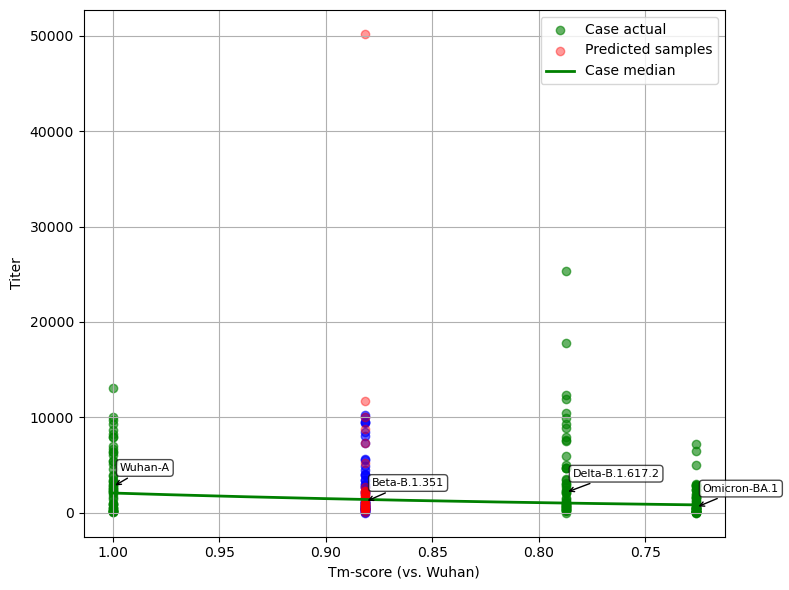

In [95]:
# Begin plotting
plt.figure(figsize=(8, 6))
labels_plotted = {'Case': False, 'Control': False, 'Predicted': False}

# Plot actual data points OR predicted samples (not both)
for variant, tm in tm_scores.items():
    if variant not in VARIANTS:
        continue
    # Check if variant exists in actual data
    variant_data = df_long[df_long['Variant'] == variant]
    has_actual_data = True
    
    if has_actual_data:
        # Use actual data points only
        if group:
            case_data = variant_data[variant_data['Group'] == 'Case']['Titer']
            control_data = variant_data[variant_data['Group'] == 'Control']['Titer']
        else:
            case_data = variant_data['Titer']
            control_data = None
        if not case_data.empty:
            if not labels_plotted['Case']:
                plt.scatter([tm]*len(case_data), case_data, color='green' if variant != "Beta-B.1.351" else 'blue', alpha=0.6, label='Case actual')
                labels_plotted['Case'] = True
            else:
                plt.scatter([tm]*len(case_data), case_data, color='green' if variant != "Beta-B.1.351" else 'blue', alpha=0.6)
        
        if control_data and not control_data.empty:
            if not labels_plotted['Control']:
                plt.scatter([tm]*len(control_data), control_data, color='red', alpha=0.6, label='Control actual')
                labels_plotted['Control'] = True
            else:
                plt.scatter([tm]*len(control_data), control_data, color='red', alpha=0.6)
    
    if variant == "Beta-B.1.351":
        # No actual data - use predictive distribution
        if group:
            preds_case = predictive_distribution(result_case, tm, n_samps=30)
            preds_ctrl = predictive_distribution(result_control, tm, n_samps=30)
            preds = np.concatenate([preds_case, preds_ctrl])
        else:
            preds_case = predictive_distribution(result_case, tm, n_samps=30)
            preds = preds_case

        
        if not labels_plotted['Predicted']:
            plt.scatter([tm]*len(preds), preds, color='red', alpha=0.4, label='Predicted samples')
            labels_plotted['Predicted'] = True
        else:
            plt.scatter([tm]*len(preds), preds, color='red', alpha=0.4)
    
    if not variant_data.empty:
        # Use median titer of actual data for label position
        if group and 'Group' in variant_data.columns:
            case_titers = variant_data[variant_data['Group'] == 'Case']['Titer']
            if not case_titers.empty:
                y_pos = case_titers.median()
            else:
                y_pos = variant_data['Titer'].median()
        else:
            y_pos = variant_data['Titer'].median()
    else:
        # Use predicted median for variants without actual data
        y_pos = 10 ** (b0_case + b1_case * tm)
    
    # Add the variant label
    plt.annotate(variant, 
                xy=(tm, y_pos + np.random.randn()*10), 
                xytext=(5, 10),  # offset from point
                textcoords='offset points',
                fontsize=8,
                ha='left',
                va='bottom',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))

# Overlay predicted median lines for Case and Control
x_line = np.linspace(min(tm_scores.values()), max(tm_scores.values()), 200)

# Case median line
b0_case = result_case.fe_params['Intercept']
b1_case = result_case.fe_params['Tm']
y_case = 10 ** (b0_case + b1_case * x_line)
plt.plot(x_line, y_case, color='green', linewidth=2, label='Case median')

if group:
    # Control median line
    b0_ctrl = model_control.result.fe_params['Intercept']
    b1_ctrl = model_control.result.fe_params['Tm']
    y_ctrl = 10 ** (b0_ctrl + b1_ctrl * x_line)
    plt.plot(x_line, y_ctrl, color='red', linewidth=2, label='Control median')

# Final touches
plt.xlabel("Tm-score (vs. Wuhan)")
plt.ylabel("Titer")
plt.gca().invert_xaxis()
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


## Beta Distribution Test

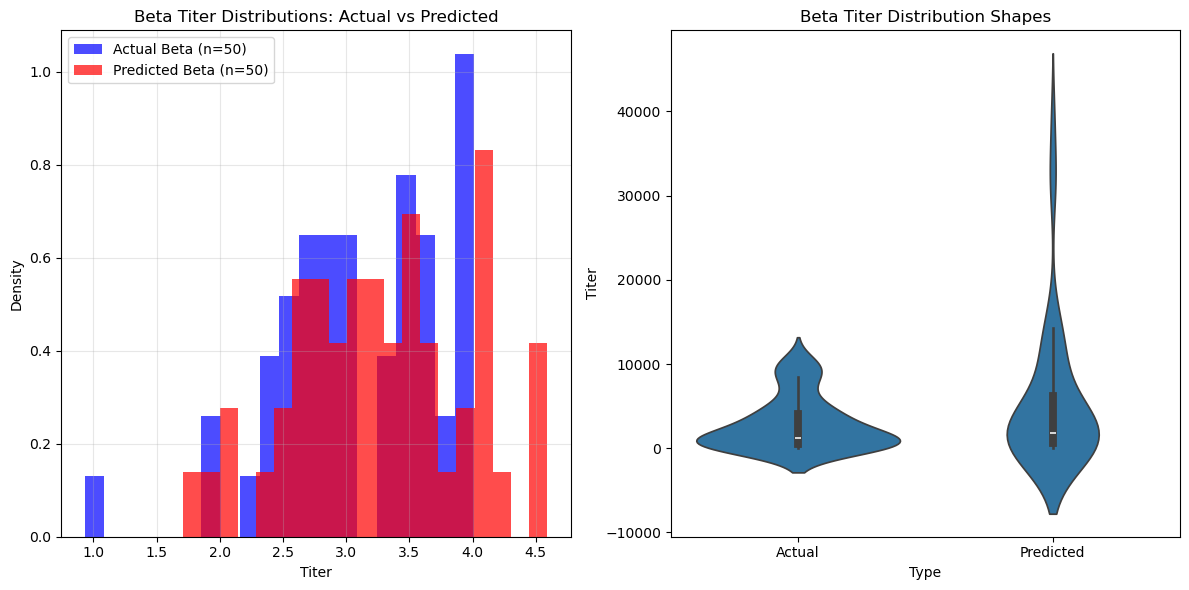

=== BETA DISTRIBUTION COMPARISON ===
Actual Beta - Mean: 2895.99, Std: 3112.70
Predicted Beta - Mean: 5488.79, Std: 8473.87

T-test: t=-2.010, p=0.047
Kolmogorov-Smirnov test: D=0.200, p=0.272
Cohen's d (effect size): -0.402


In [96]:

# Generate Beta samples and compare with actual data
plt.figure(figsize=(12, 6))

# Get actual Beta titers
beta_actual = df_long[df_long['Variant'] == 'Beta-B.1.351']['Titer'].values
beta_actual_log = np.log10(beta_actual)

# Generate predicted Beta titers using predict_population (or predictive_distribution)
beta_tm_score = tm_scores['Beta-B.1.351']
beta_predicted = predictive_distribution(model_case.result, beta_tm_score, n_samps=50)
beta_predicted_log = np.log10(beta_predicted)

# Or if using predictive_distribution:
# beta_predicted = predictive_distribution(model_case.result, beta_tm_score, n_samps=1000)

# Create side-by-side distribution comparison
plt.subplot(1, 2, 1)
plt.hist(beta_actual_log, bins=20, alpha=0.7, color='blue', label=f'Actual Beta (n={len(beta_actual)})', density=True)
plt.hist(beta_predicted_log, bins=20, alpha=0.7, color='red', label=f'Predicted Beta (n={len(beta_predicted)})', density=True)
plt.xlabel('Titer')
plt.ylabel('Density')
plt.title('Beta Titer Distributions: Actual vs Predicted')
plt.legend()
plt.grid(True, alpha=0.3)

# Create violin plot comparison
plt.subplot(1, 2, 2)
data_for_violin = pd.DataFrame({
    'Titer': np.concatenate([beta_actual, beta_predicted]),
    'Type': ['Actual'] * len(beta_actual) + ['Predicted'] * len(beta_predicted)
})
sns.violinplot(data=data_for_violin, x='Type', y='Titer', ax=plt.gca())
plt.title('Beta Titer Distribution Shapes')
plt.ylabel('Titer')

plt.tight_layout()
plt.show()

# Statistical comparison
from scipy import stats
t_stat, p_value = stats.ttest_ind(beta_actual, beta_predicted)
ks_stat, ks_p_value = stats.ks_2samp(beta_actual, beta_predicted)

print("=== BETA DISTRIBUTION COMPARISON ===")
print(f"Actual Beta - Mean: {np.mean(beta_actual):.2f}, Std: {np.std(beta_actual):.2f}")
print(f"Predicted Beta - Mean: {np.mean(beta_predicted):.2f}, Std: {np.std(beta_predicted):.2f}")
print(f"\nT-test: t={t_stat:.3f}, p={p_value:.3f}")
print(f"Kolmogorov-Smirnov test: D={ks_stat:.3f}, p={ks_p_value:.3f}")

# Effect size
pooled_std = np.sqrt(((len(beta_actual)-1)*np.var(beta_actual, ddof=1) + 
                     (len(beta_predicted)-1)*np.var(beta_predicted, ddof=1)) / 
                    (len(beta_actual) + len(beta_predicted) - 2))
cohens_d = (np.mean(beta_actual) - np.mean(beta_predicted)) / pooled_std
print(f"Cohen's d (effect size): {cohens_d:.3f}")

## Validation

In [97]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
import pandas as pd
import seaborn as sns

def run_validation_iteration(df_long, tm_scores, n_samps=100, random_seed=None):
    """Run one iteration of validation with random sampling"""
    if random_seed is not None:
        np.random.seed(random_seed)
    
    results = []
    
    for validation in ["Beta-B.1.351", "Delta-B.1.617.2", "Omicron-BA.1"]:
        df_valid = df_long[df_long["Variant"] == validation]
        df_train = df_long[df_long["Variant"] != validation]
        
        # Fit model on training data
        model_case = TiterModel()
        result_case = model_case.fit(df_train, tm_scores, formula="log10_Titer ~ Tm")
        
        # Get actual titers
        validation_titer = df_valid["Titer"].values
        
        # Generate predictions
        predicted_titer = predictive_distribution(result_case, tm_scores[validation], n_samps=n_samps)
        
        # Statistical comparison
        t_stat, p_value = stats.ttest_ind(validation_titer, predicted_titer)
        
        # Effect size (Cohen's d)
        pooled_std = np.sqrt(((len(validation_titer)-1)*np.var(validation_titer, ddof=1) + 
                             (len(predicted_titer)-1)*np.var(predicted_titer, ddof=1)) / 
                            (len(validation_titer) + len(predicted_titer) - 2))
        cohens_d = (np.mean(validation_titer) - np.mean(predicted_titer)) / pooled_std
        
        # Mean squared error
        # For MSE, compare to mean of predictions
        pred_mean = np.mean(predicted_titer)
        mse = np.mean((validation_titer - pred_mean)**2)
        
        results.append({
            'variant': validation,
            'p_value': p_value,
            't_statistic': t_stat,
            'cohens_d': cohens_d,
            'mse': mse,
            'actual_mean': np.mean(validation_titer),
            'predicted_mean': np.mean(predicted_titer),
            'actual_std': np.std(validation_titer),
            'predicted_std': np.std(predicted_titer)
        })
    
    return results

# Run multiple validation iterations
n_iterations = 50
all_results = []

print(f"Running {n_iterations} validation iterations...")
for i in range(n_iterations):
    iteration_results = run_validation_iteration(df_long, tm_scores, random_seed=i)
    for result in iteration_results:
        result['iteration'] = i
        all_results.append(result)

# Convert to DataFrame for easier analysis
results_df = pd.DataFrame(all_results)
print(f"Completed {n_iterations} iterations for {len(results_df)} total validation tests")

results_df.groupby("variant").agg({
    'p_value': ['mean', 'std', lambda x: (x < 0.05).mean()],
    't_statistic': ['mean', 'std'],
    'cohens_d': ['mean', 'std'],
    'mse': ['mean', 'std'],
    'actual_mean': ['mean', 'std'],
    'predicted_mean': ['mean', 'std'],
    'actual_std': ['mean', 'std'],
    'predicted_std': ['mean', 'std']
})


Running 50 validation iterations...
Completed 50 iterations for 150 total validation tests


p_value                      t_statistic            \
                     mean       std <lambda_0>        mean       std   
variant                                                                
Beta-B.1.351     0.296652  0.179089       0.00   -1.116647  0.380584   
Delta-B.1.617.2  0.186646  0.253223       0.44    1.886731  1.152083   
Omicron-BA.1     0.038402  0.059794       0.78   -2.434715  0.580683   

                 cohens_d                     mse                actual_mean  \
                     mean       std          mean           std         mean   
variant                                                                        
Beta-B.1.351    -0.193409  0.065919  1.420052e+07  6.454442e+06  2895.992133   
Delta-B.1.617.2  0.326791  0.199547  2.764499e+07  1.941373e+06  4000.704677   
Omicron-BA.1    -0.421705  0.100577  2.264317e+07  3.213341e+07  1279.568006   

                     predicted_mean                actual_std       \
                 std           mean          std         mean  std   
variant                                                              
Beta-B.1.351     0.0    4681.681541  1161.852313  3112.704107  0.0   
Delta-B.1.617.2  0.0    2557.662403  1007.543533  4956.589807  0.0   
Omicron-BA.1     0.0    5190.070875  2228.294269  1576.433672  0.0   

                predicted_std                
                         mean           std  
variant                                      
Beta-B.1.351     10303.864986   5074.889448  
Delta-B.1.617.2   6741.569185   6402.039993  
Omicron-BA.1     13178.989735  12929.641396

## All Variants Predicted

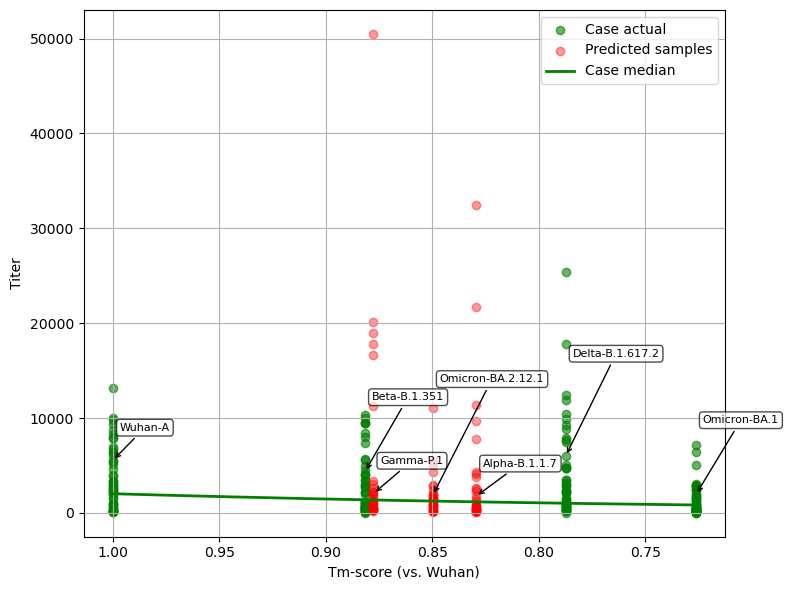

In [110]:
model_case = TiterModel()
result_case = model_case.fit(df_long, tm_scores, formula="log10_Titer ~ Tm")

b0_case = result_case.fe_params['Intercept']
b1_case = result_case.fe_params['Tm']
cnt = 0
offset = [0, 0, 30, 50, 0, 30, 60]
# Begin plotting
plt.figure(figsize=(8, 6))
labels_plotted = {'Case': False, 'Control': False, 'Predicted': False}

# Plot actual data points OR predicted samples (not both)
for variant, tm in tm_scores.items():
    # Check if variant exists in actual data
    variant_data = df_long[df_long['Variant'] == variant]
    has_actual_data = variant in df_long["Variant"].unique()
    
    if has_actual_data:
        # Use actual data points only
        if group:
            case_data = variant_data[variant_data['Group'] == 'Case']['Titer']
            control_data = variant_data[variant_data['Group'] == 'Control']['Titer']
        else:
            case_data = variant_data['Titer']
            control_data = None
        if not case_data.empty:
            if not labels_plotted['Case']:
                plt.scatter([tm]*len(case_data), case_data, color='green', alpha=0.6, label='Case actual')
                labels_plotted['Case'] = True
            else:
                plt.scatter([tm]*len(case_data), case_data, color='green', alpha=0.6)
        
        if control_data and not control_data.empty:
            if not labels_plotted['Control']:
                plt.scatter([tm]*len(control_data), control_data, color='red', alpha=0.6, label='Control actual')
                labels_plotted['Control'] = True
            else:
                plt.scatter([tm]*len(control_data), control_data, color='red', alpha=0.6)
    
    else:
        # No actual data - use predictive distribution
        if group:
            preds_case = predictive_distribution(result_case, tm, n_samps=30)
            preds_ctrl = predictive_distribution(result_control, tm, n_samps=30)
            preds = np.concatenate([preds_case, preds_ctrl])
        else:
            preds_case = predictive_distribution(result_case, tm, n_samps=30)
            preds = preds_case

        
        if not labels_plotted['Predicted']:
            plt.scatter([tm]*len(preds), preds, color='red', alpha=0.4, label='Predicted samples')
            labels_plotted['Predicted'] = True
        else:
            plt.scatter([tm]*len(preds), preds, color='red', alpha=0.4)
    
    if not variant_data.empty:
        # Use median titer of actual data for label position
        if group and 'Group' in variant_data.columns:
            case_titers = variant_data[variant_data['Group'] == 'Case']['Titer']
            if not case_titers.empty:
                y_pos = case_titers.mean()
            else:
                y_pos = variant_data['Titer'].mean()
        else:
            y_pos = variant_data['Titer'].mean()
    else:
        # Use predicted median for variants without actual data
        y_pos = 10 ** (b0_case + b1_case * tm)
    
    # Add the variant label
    plt.annotate(variant, 
                xy=(tm, y_pos * 1.5), 
                xytext=(5, 20 + offset[cnt]),  # offset from point
                textcoords='offset points',
                fontsize=8,
                ha='left',
                va='bottom',
                bbox=dict(boxstyle='round,pad=0.3', facecolor='white', alpha=0.7),
                arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
    cnt += 1
    

# Overlay predicted median lines for Case and Control
x_line = np.linspace(min(tm_scores.values()), max(tm_scores.values()), 200)

# Case median line
b0_case = result_case.fe_params['Intercept']
b1_case = result_case.fe_params['Tm']
y_case = 10 ** (b0_case + b1_case * x_line)
plt.plot(x_line, y_case, color='green', linewidth=2, label='Case median')

if group:
    # Control median line
    b0_ctrl = model_control.result.fe_params['Intercept']
    b1_ctrl = model_control.result.fe_params['Tm']
    y_ctrl = 10 ** (b0_ctrl + b1_ctrl * x_line)
    plt.plot(x_line, y_ctrl, color='red', linewidth=2, label='Control median')

# Final touches
plt.xlabel("Tm-score (vs. Wuhan)")
plt.ylabel("Titer")
plt.gca().invert_xaxis()
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


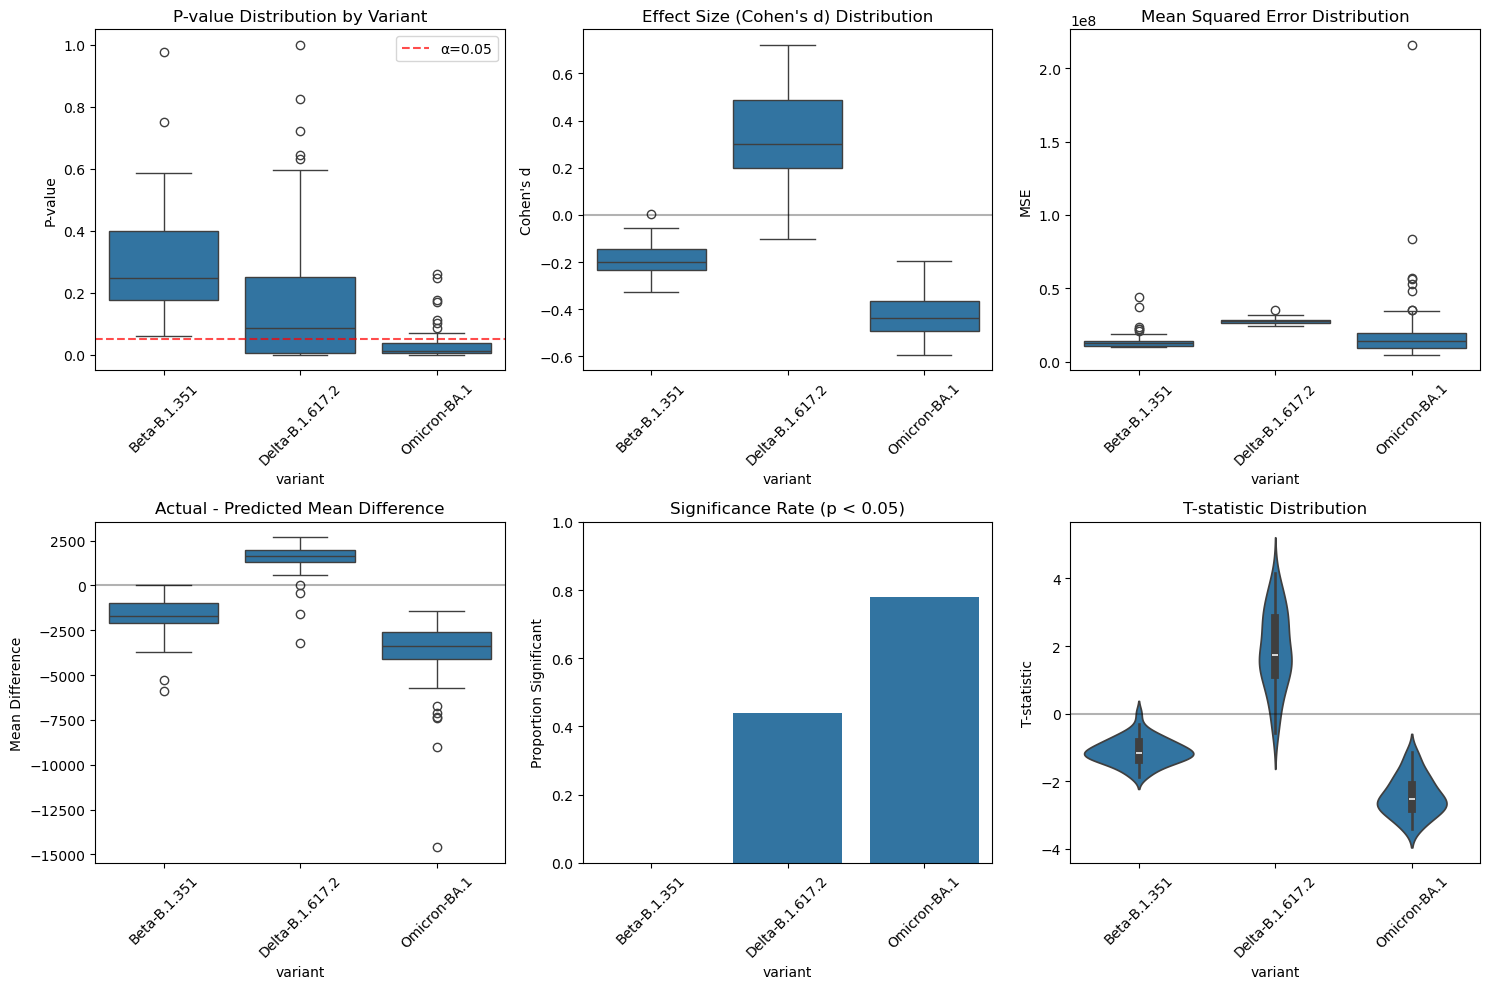

\n=== VALIDATION SUMMARY STATISTICS ===
                 p_value_mean  p_value_std  p_value_<lambda_0>  cohens_d_mean  \
variant                                                                         
Beta-B.1.351           0.2967       0.1791                0.00        -0.1934   
Delta-B.1.617.2        0.1866       0.2532                0.44         0.3268   
Omicron-BA.1           0.0384       0.0598                0.78        -0.4217   

                 cohens_d_std      mse_mean       mse_std  \
variant                                                     
Beta-B.1.351           0.0659  1.420052e+07  6.454442e+06   
Delta-B.1.617.2        0.1995  2.764499e+07  1.941373e+06   
Omicron-BA.1           0.1006  2.264317e+07  3.213341e+07   

                 mean_difference_mean  mean_difference_std  
variant                                                     
Beta-B.1.351               -1785.6894            1161.8523  
Delta-B.1.617.2             1443.0423            1007.5435  
Omic

In [99]:
# Create comprehensive validation visualizations
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# 1. P-value distributions
sns.boxplot(data=results_df, x='variant', y='p_value', ax=axes[0, 0])
axes[0, 0].set_title('P-value Distribution by Variant')
axes[0, 0].axhline(y=0.05, color='red', linestyle='--', alpha=0.7, label='α=0.05')
axes[0, 0].legend()
axes[0, 0].set_ylabel('P-value')

# 2. Effect size (Cohen's d) distributions
sns.boxplot(data=results_df, x='variant', y='cohens_d', ax=axes[0, 1])
axes[0, 1].set_title("Effect Size (Cohen's d) Distribution")
axes[0, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[0, 1].set_ylabel("Cohen's d")

# 3. Mean Squared Error distributions
sns.boxplot(data=results_df, x='variant', y='mse', ax=axes[0, 2])
axes[0, 2].set_title('Mean Squared Error Distribution')
axes[0, 2].set_ylabel('MSE')

# 4. Actual vs Predicted means comparison
results_df['mean_difference'] = results_df['actual_mean'] - results_df['predicted_mean']
sns.boxplot(data=results_df, x='variant', y='mean_difference', ax=axes[1, 0])
axes[1, 0].set_title('Actual - Predicted Mean Difference')
axes[1, 0].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 0].set_ylabel('Mean Difference')

# 5. Significance rate by variant
sig_rates = results_df.groupby('variant')['p_value'].apply(lambda x: (x < 0.05).mean()).reset_index()
sig_rates.columns = ['variant', 'significance_rate']
sns.barplot(data=sig_rates, x='variant', y='significance_rate', ax=axes[1, 1])
axes[1, 1].set_title('Significance Rate (p < 0.05)')
axes[1, 1].set_ylabel('Proportion Significant')
axes[1, 1].set_ylim(0, 1)

# 6. T-statistic distributions
sns.violinplot(data=results_df, x='variant', y='t_statistic', ax=axes[1, 2])
axes[1, 2].set_title('T-statistic Distribution')
axes[1, 2].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 2].set_ylabel('T-statistic')

# Rotate x-axis labels for better readability
for ax in axes.flat:
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Summary statistics table
print("\\n=== VALIDATION SUMMARY STATISTICS ===")
summary_stats = results_df.groupby('variant').agg({
    'p_value': ['mean', 'std', lambda x: (x < 0.05).mean()],
    'cohens_d': ['mean', 'std'],
    'mse': ['mean', 'std'],
    'mean_difference': ['mean', 'std']
}).round(4)

summary_stats.columns = ['_'.join(col).strip() for col in summary_stats.columns]
summary_stats = summary_stats.rename(columns={
    'p_value_<lambda>': 'p_value_sig_rate',
    'p_value_mean': 'p_value_mean',
    'p_value_std': 'p_value_std'
})

print(summary_stats)


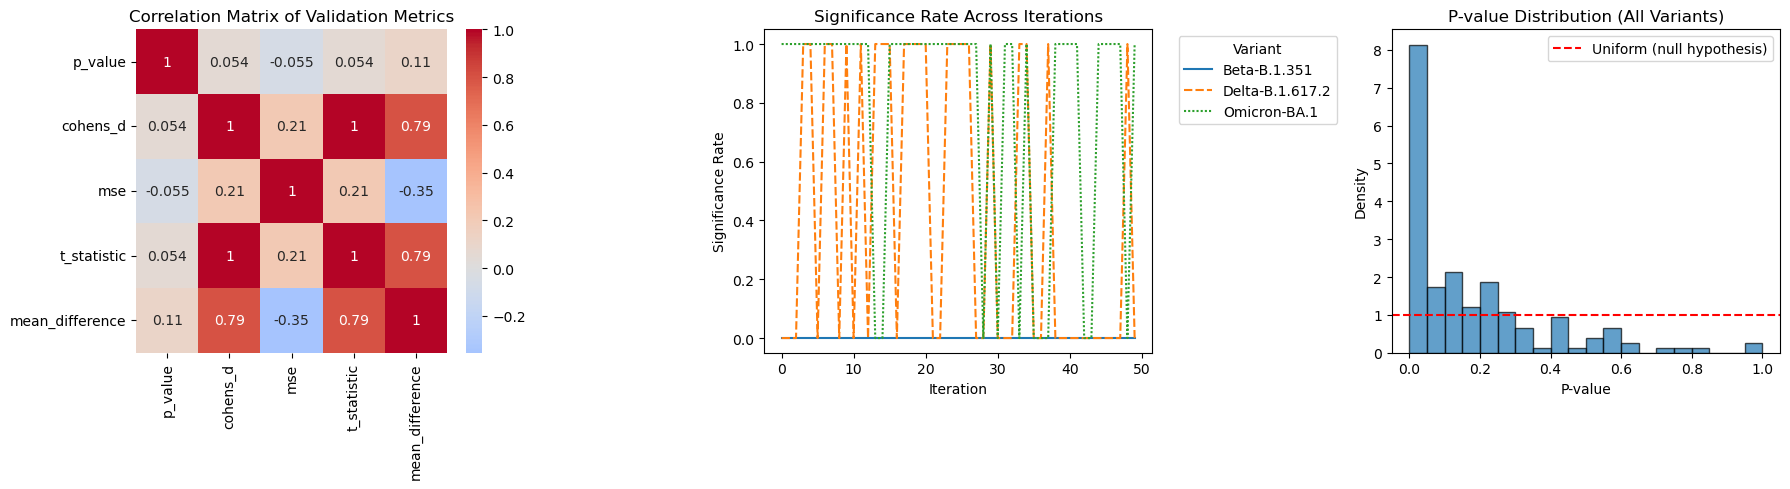

\n=== POWER ANALYSIS ===
Overall statistical power (% significant): 40.67%
Beta-B.1.351: 0.00% of tests significant
Delta-B.1.617.2: 44.00% of tests significant
Omicron-BA.1: 78.00% of tests significant
\n=== EFFECT SIZE INTERPRETATION ===
Beta-B.1.351: Cohen's d = -0.193 (negligible effect size)
Delta-B.1.617.2: Cohen's d = 0.327 (small effect size)
Omicron-BA.1: Cohen's d = -0.422 (small effect size)
\n=== VALIDATION ROBUSTNESS ===
Standard deviations of metrics across iterations:
\nP_VALUE:
  Beta-B.1.351: 0.1791
  Delta-B.1.617.2: 0.2532
  Omicron-BA.1: 0.0598
\nCOHENS_D:
  Beta-B.1.351: 0.0659
  Delta-B.1.617.2: 0.1995
  Omicron-BA.1: 0.1006
\nMSE:
  Beta-B.1.351: 6454442.0937
  Delta-B.1.617.2: 1941373.1270
  Omicron-BA.1: 32133408.5785


In [100]:
# Additional validation visualizations
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# 1. Correlation matrix heatmap of validation metrics
metrics_corr = results_df[['p_value', 'cohens_d', 'mse', 't_statistic', 'mean_difference']].corr()
sns.heatmap(metrics_corr, annot=True, cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title('Correlation Matrix of Validation Metrics')

# 2. Validation consistency across iterations
iteration_summary = results_df.groupby(['iteration', 'variant'])['p_value'].apply(lambda x: (x < 0.05).mean()).reset_index()
iteration_pivot = iteration_summary.pivot(index='iteration', columns='variant', values='p_value')
sns.lineplot(data=iteration_pivot, ax=axes[1])
axes[1].set_title('Significance Rate Across Iterations')
axes[1].set_ylabel('Significance Rate')
axes[1].set_xlabel('Iteration')
axes[1].legend(title='Variant', bbox_to_anchor=(1.05, 1), loc='upper left')

# 3. Distribution of p-values (should be uniform under null hypothesis)
axes[2].hist(results_df['p_value'], bins=20, alpha=0.7, density=True, edgecolor='black')
axes[2].axhline(y=1, color='red', linestyle='--', label='Uniform (null hypothesis)')
axes[2].set_title('P-value Distribution (All Variants)')
axes[2].set_xlabel('P-value')
axes[2].set_ylabel('Density')
axes[2].legend()

plt.tight_layout()
plt.show()

# Power analysis: what percentage of tests are significant?
print("\\n=== POWER ANALYSIS ===")
overall_power = (results_df['p_value'] < 0.05).mean()
print(f"Overall statistical power (% significant): {overall_power:.2%}")

for variant in results_df['variant'].unique():
    variant_power = (results_df[results_df['variant'] == variant]['p_value'] < 0.05).mean()
    print(f"{variant}: {variant_power:.2%} of tests significant")

# Effect size interpretation
print("\\n=== EFFECT SIZE INTERPRETATION ===")
for variant in results_df['variant'].unique():
    variant_data = results_df[results_df['variant'] == variant]
    mean_d = variant_data['cohens_d'].mean()
    
    if abs(mean_d) < 0.2:
        interpretation = "negligible"
    elif abs(mean_d) < 0.5:
        interpretation = "small"
    elif abs(mean_d) < 0.8:
        interpretation = "medium"
    else:
        interpretation = "large"
    
    print(f"{variant}: Cohen's d = {mean_d:.3f} ({interpretation} effect size)")

print("\\n=== VALIDATION ROBUSTNESS ===")
print("Standard deviations of metrics across iterations:")
for metric in ['p_value', 'cohens_d', 'mse']:
    metric_std = results_df.groupby('variant')[metric].std()
    print(f"\\n{metric.upper()}:")
    for variant in metric_std.index:
        print(f"  {variant}: {metric_std[variant]:.4f}")
